In [167]:
import torch
import torch.nn as nn
from torchvision.models import resnet18
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [168]:
def D(p, z):
    z = z.detach() # we don't backpropagate here
    p = F.normalize(p, dim=1)
    z = F.normalize(z, dim=1)
    return -(p*z).sum(dim=1).mean()

In [169]:
class ProjectionMLP(nn.Module):
    """Projection MLP f"""
    def __init__(self, in_features, h1_features, h2_features, out_features):
        super(ProjectionMLP, self).__init__()
        self.l1 = nn.Sequential(
            nn.Linear(in_features, h1_features),
            nn.BatchNorm1d(h1_features),
            nn.ReLU(inplace=True)
        )
        self.l2 = nn.Sequential(
            nn.Linear(h1_features, h2_features),
            nn.BatchNorm1d(h2_features),
            nn.ReLU(inplace=True)

        )
        self.l3 = nn.Sequential(
            nn.Linear(h2_features, out_features),
            nn.BatchNorm1d(out_features)
        )

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        return x


In [170]:
class PredictionMLP(nn.Module):
    """Prediction MLP h"""
    def __init__(self, in_features, hidden_features, out_features):
        super(PredictionMLP, self).__init__()
        self.l1 = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.BatchNorm1d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.l2 = nn.Linear(hidden_features, out_features)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        return x

In [171]:
class SimSiam(nn.Module):
    def __init__(self):
        super(SimSiam, self).__init__()
        backbone = resnet18(weights=True) # TODO: Should weights be pretrained?
        num_ftrs = backbone.fc.in_features
        
        self.model = nn.Sequential(*list(backbone.children())[:-1])
        self.projection = ProjectionMLP(num_ftrs, 2048, 2048, 2048)
        self.prediction = PredictionMLP(2048, 512, 2048)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1) # TODO
        z = self.projection(x)
        p = self.prediction(z)
        return z, p
        

In [172]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # ((mean, mean, mean), (std, std, st))

In [173]:
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


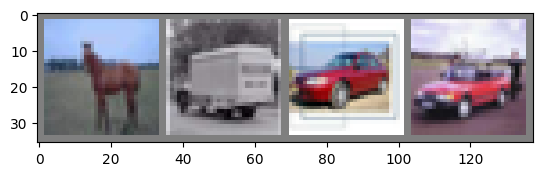

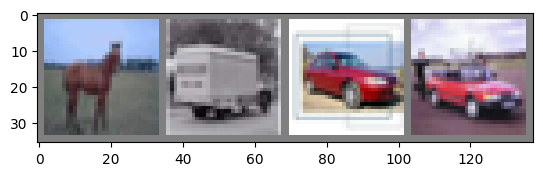

In [174]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def random_aug(image):
    augmentations =["colorjitter", "randomhorizontalflip", "randomcrop", "randomgrayscale"]

    augmentation = np.random.choice(augmentations)

    if augmentation == "randomhorizontalflip":
        transform = transforms.RandomHorizontalFlip(1)
    elif augmentation == "randomcrop":
        transform = transforms.RandomCrop(20)
    elif augmentation == "randomgrayscale":
        transform = transforms.RandomGrayscale(0.2)
    elif augmentation == "colorjitter":
        transform = transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8)

    augmented_img = transform(image)
    return augmented_img


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

# random augmentation
flipped_images = random_aug(images)
imshow(torchvision.utils.make_grid(flipped_images))


In [ ]:
# KNN classification accuracy:


In [175]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = SimSiam()
model = model.to(device)

/home/jonas/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [176]:
# criterion = nn.CrossEntropyLoss() # Got our own loss
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=0.0005)

In [177]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):            
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # random augmentations:
        x1 = random_aug(images)
        x2 = random_aug(images)
        
        # forward + backward + optimize
        z1, p1 = model(x1)
        z2, p2 = model(x2)
        #loss = criterion(outputs, labels)
        loss = D(p1, z2)/2 + D(p2, z1)/2
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

KeyboardInterrupt: 